In [43]:
# Установка необходимых библиотек
!pip install librosa soundfile numpy scikit-learn matplotlib kagglehub

import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import soundfile as sf
from google.colab import files
from IPython.display import Audio
import zipfile

In [44]:
# 1. Загрузка датасета GTZAN через Kaggle Hub
import kagglehub

# Скачиваем датасет
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [45]:
# 2. Создаем свою классификацию (Happy/Sad) на основе жанров
# Предположим, что:
# Happy: disco, pop, rock, hiphop
# Sad: blues, jazz, classical, country, reggae, metal

genre_to_emotion = {
    'blues': 'sad',
    'classical': 'sad',
    'country': 'sad',
    'disco': 'happy',
    'hiphop': 'happy',
    'jazz': 'sad',
    'metal': 'sad',
    'pop': 'happy',
    'reggae': 'happy',
    'rock': 'happy'
}


In [46]:
# 3. Извлечение признаков (MFCC)
def extract_features(file_path, mfcc_count=13):
    try:
        audio, sr = librosa.load(file_path, sr=None, duration=30)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=mfcc_count)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)[:100]}...")
        return None

# 4. Подготовка данных
def load_data(dataset_path):
    features = []
    labels = []

    for genre_folder in os.listdir(dataset_path):
        genre_path = os.path.join(dataset_path, genre_folder)
        if os.path.isdir(genre_path):
            emotion = genre_to_emotion.get(genre_folder, None)
            if emotion is not None:
                for file in os.listdir(genre_path):
                    if file.endswith('.wav'):
                        file_path = os.path.join(genre_path, file)
                        # Пропускаем проблемный файл
                        if 'jazz.00054.wav' in file_path:
                            continue
                        mfcc = extract_features(file_path)
                        if mfcc is not None:
                            features.append(mfcc)
                            labels.append(1 if emotion == 'happy' else 0)

    return np.array(features), np.array(labels)

In [47]:
# Загрузка данных
dataset_path = os.path.join(path, "Data/genres_original")
X, y = load_data(dataset_path)

# 5. Разделение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# 6. Обучение модели (SVM)
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

# 7. Оценка точности
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy * 100:.2f}%")

# 8. Визуализация MFCC
def plot_mfcc(file_path):
    audio, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.show()

Точность модели: 81.00%


In [49]:
happy_example = os.path.join(dataset_path, "disco/disco.00000.wav")
Audio(happy_example)

Happy example (disco):


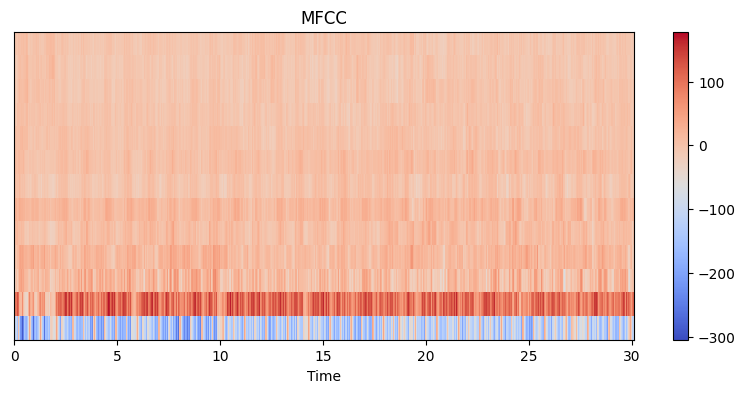

In [50]:
print("Happy example (disco):")
plot_mfcc(happy_example)

In [51]:
sad_example = os.path.join(dataset_path, "classical/classical.00000.wav")
Audio(sad_example)

Sad example (blues):


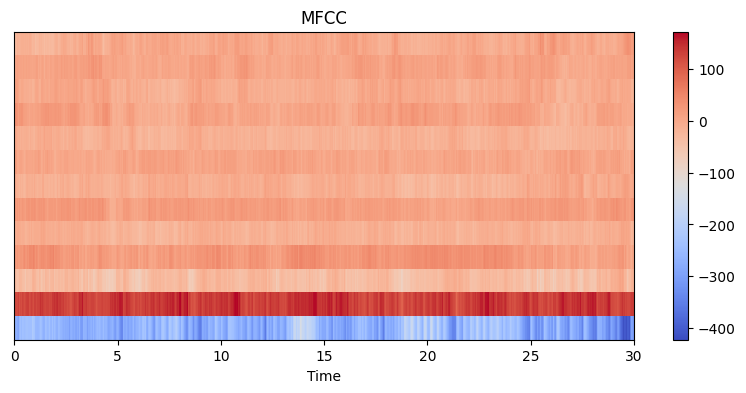

In [52]:
print("Sad example (blues):")
plot_mfcc(sad_example)

In [53]:
# 9. Тест на своем аудио (загрузка в Colab)
def predict_emotion(file_path):
    mfcc = extract_features(file_path)
    if mfcc is not None:
        proba = model.predict_proba([mfcc])[0]
        emotion = "Happy" if np.argmax(proba) == 1 else "Sad"
        print(f"Результат: {emotion} (Вероятность: Happy={proba[1]:.2f}, Sad={proba[0]:.2f})")

# Загрузите свой файл
print("Загрузите свой аудиофайл в формате WAV:")
uploaded = files.upload()
for file_name in uploaded.keys():
    predict_emotion(file_name)

Загрузите свой аудиофайл в формате WAV:


Saving 2.wav to 2 (1).wav
Результат: Sad (Вероятность: Happy=0.36, Sad=0.64)
